# stadvdbvdvbdbvbdb mco1

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Database Connection Setup

In [2]:
# MySQL Connection Details 

username = "root"
password = "admin"
host = "localhost"
port = "3306"
database = "stadvdb_imdb"

engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}")

try:
    with engine.connect() as conn:
        tables = pd.read_sql("SHOW TABLES;", conn)
    print("Successfully connected to the database!")
    display(tables)
except Exception as e:
    print("Connection failed:", e)

Successfully connected to the database!


,Tables_in_stadvdb_imdb
0,dim_movie
1,director_profession_bridge
2,directors_dt
3,genre_dt
4,name_basics
5,profession_dt
6,title_akas
7,title_basics
8,title_crew
9,title_director_bridge


In [3]:
# Query to count rows per table
table_names = [
    "dim_movie", "director_profession_bridge", "directors_dt", "genre_dt",
    "name_basics", "profession_dt", "title_akas", "title_basics",
    "title_crew", "title_director_bridge", "title_episode", "title_ft",
    "title_genre_bridge", "title_principals", "title_ratings", "type_dt"
]

counts = []
with engine.connect() as conn:
    for table in table_names:
        result = pd.read_sql(f"SELECT COUNT(*) AS row_count FROM {table};", conn)
        counts.append({"table_name": table, "row_count": int(result['row_count'][0])})

pd.DataFrame(counts).sort_values(by="row_count", ascending=False)


,table_name,row_count
13,title_principals,92485887
6,title_akas,44190547
12,title_genre_bridge,15167823
8,title_crew,11932624
4,name_basics,10293867
11,title_ft,9775512
7,title_basics,9775512
10,title_episode,9188140
9,title_director_bridge,5877051
14,title_ratings,1617103


# Movie Search Queries
1. Be able to search keywords
2. By star rating (ex. 1.0 to 1.9)
  - Has a weighted system for higher vote counts
3. Filtering by genre
4. Have settable minimum number of votes

All queries will use the tables:
- `dim_movie` – Main movie details (title, year, genre, etc.)
- `title_ratings` – Average rating and vote counts
- `title_genre_bridge` and `genre_dt` – For genre relationships

In [4]:
# Search Movies by Keyword
def search_movies_by_keyword(keyword, limit=10):
    query = text(f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            m.startYear,
            r.averageRating,
            r.numVotes
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE m.primaryTitle LIKE :keyword
        ORDER BY r.averageRating DESC
        LIMIT :limit;
    """)
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"keyword": f"%{keyword}%", "limit": limit})
        end = time.time()
    
    print(f"Query executed in {end - start:.3f} seconds")
    return df

# Example usage
search_movies_by_keyword("Matrix", limit=10)
search_movies_by_keyword("Boys", limit=10)
search_movies_by_keyword("Love", limit=10)

Query executed in 0.511 seconds
Query executed in 0.330 seconds
Query executed in 0.553 seconds


,tconst,title,startYear,averageRating,numVotes
0,tt28230767,Puppy Love,2023.0,9.8,12
1,tt37805816,Dara: A Port Harcourt Love Story?,2025.0,9.8,16
2,tt23900278,For the Love of Friends,2022.0,9.8,9
3,tt5370158,Love & Justice: In the Footsteps of Beethoven'...,2023.0,9.7,12
4,tt15830504,The Love Square,2021.0,9.7,11
5,tt10950526,Love Goes Public,2019.0,9.6,15
6,tt38063160,The Cycle of Love,2025.0,9.6,12
7,tt21871222,What Is Love?,2023.0,9.6,10
8,tt27719331,Turn Up the Love: Connecting to Pride,2023.0,9.6,17
9,tt35694518,From China with Love,2025.0,9.5,548


In [5]:
# Filter Movies by Rating Range with Weighting

def filter_by_rating_range(min_rating, max_rating, min_votes=1000, limit=10):
    with engine.connect() as conn:
        avg_query = "SELECT AVG(averageRating) AS C FROM title_ratings;"
        C = pd.read_sql(avg_query, conn)['C'][0]
        
        m = min_votes

        query = f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            r.averageRating AS R,
            r.numVotes AS v,
            ((r.numVotes / (r.numVotes + {m})) * r.averageRating 
             + ({m} / (r.numVotes + {m})) * {C}) AS weighted_rating
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE r.averageRating BETWEEN {min_rating} AND {max_rating}
        AND r.numVotes >= {m}
        ORDER BY weighted_rating DESC
        LIMIT {limit};
        """
        start = time.time()
        df = pd.read_sql(query, conn)
        end = time.time()
    
    print(f"Query executed in {end - start:.3f} seconds")
    return df

# Example usage
filter_by_rating_range(1.0, 1.9, min_votes=5000, limit=10)
filter_by_rating_range(2.0, 2.9, min_votes=5000, limit=10)
filter_by_rating_range(3.0, 3.9, min_votes=5000, limit=10)

Query executed in 0.355 seconds
Query executed in 0.317 seconds
Query executed in 0.643 seconds


,tconst,title,R,v,weighted_rating
0,tt29856129,Mayanagari,3.9,5081,5.408045
1,tt13259610,The Outwaters,3.9,5223,5.387098
2,tt8363392,Blackout,3.9,5299,5.376124
3,tt0053611,Attack of the Giant Leeches,3.8,5163,5.345075
4,tt12311866,Children of the Corn,3.8,5173,5.343556
5,tt0095382,Iron Eagle II,3.9,5665,5.325466
6,tt35518081,Ask Sadece Bir An,3.8,5304,5.323932
7,tt0476550,God Tussi Great Ho,3.8,5321,5.321422
8,tt11563070,Acharya,3.8,5381,5.312629
9,tt0949751,The Masked Gang: Iraq,3.9,5826,5.304267


In [6]:
# Filter Movies by Genre

def filter_by_genre(genreName, limit=10):
    query = text(f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            g.genreName AS genre,
            r.averageRating,
            r.numVotes
        FROM dim_movie AS m
        JOIN title_genre_bridge AS tg ON m.tconst = tg.tconst
        JOIN genre_dt AS g ON tg.genreID = g.genreID
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE g.genreName = :genre
        ORDER BY r.averageRating DESC
        LIMIT :limit;
    """)
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"genre": genreName, "limit": limit})
        end = time.time()
    
    print(f"Query executed in {end - start:.3f} seconds")
    return df

# Example usage
filter_by_genre("Drama", limit=10)
filter_by_genre("Action", limit=10)
filter_by_genre("Romance", limit=10)

Query executed in 10.034 seconds
Query executed in 5.721 seconds
Query executed in 10.445 seconds


,tconst,title,genre,averageRating,numVotes
0,tt28786905,Idem,Romance,9.8,8
1,tt21410874,Get Over It,Romance,9.7,11
2,tt21345048,Tahanan (Home),Romance,9.7,29
3,tt33808546,Green Girl,Romance,9.7,11
4,tt15830504,The Love Square,Romance,9.7,11
5,tt18815714,Prem Prakaran,Romance,9.6,83
6,tt15282112,Bablee,Romance,9.6,47
7,tt15768458,Tailor My Heart,Romance,9.6,10
8,tt26733913,Sakhi,Romance,9.6,23
9,tt27301253,Umbrella,Romance,9.6,47


In [7]:
# Filter by Minimum Votes

def filter_by_min_votes(min_votes=5000, limit=10):
    query = f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            r.averageRating,
            r.numVotes
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE r.numVotes >= {min_votes}
        ORDER BY r.averageRating DESC
        LIMIT {limit};
    """
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn)
        end = time.time()
    
    print(f"Query executed in {end - start:.3f} seconds")
    return df

# Example usage
filter_by_min_votes(min_votes=10000, limit=10)
filter_by_min_votes(min_votes=20000, limit=10)
filter_by_min_votes(min_votes=30000, limit=10)

Query executed in 1.745 seconds
Query executed in 1.299 seconds
Query executed in 0.809 seconds


,tconst,title,averageRating,numVotes
0,tt0111161,The Shawshank Redemption,9.3,3101449
1,tt0252487,The Chaos Class,9.2,45059
2,tt0068646,The Godfather,9.2,2161418
3,tt0468569,The Dark Knight,9.1,3076473
4,tt0167260,The Lord of the Rings: The Return of the King,9.0,2108342
5,tt0108052,Schindler's List,9.0,1546570
6,tt0071562,The Godfather Part II,9.0,1452533
7,tt0050083,12 Angry Men,9.0,949034
8,tt5354160,Mirror Game,8.9,30757
9,tt34365591,Mahavatar Narsimha,8.9,37588


### Cosine Similarity

to find similar movies based on cosine similarity

In [ ]:
# Cosine Similarity Setup ---

print("Fetching normalization stats and genre list...")
stats_query = """
    SELECT 
        MIN(averageRating) AS min_rating, MAX(averageRating) AS max_rating,
        MIN(numVotes) AS min_votes, MAX(numVotes) AS max_votes,
        MIN(runtimeMinutes) AS min_runtime, MAX(runtimeMinutes) AS max_runtime
    FROM title_ft
    WHERE numVotes > 1000; 
"""
with engine.connect() as conn:
    stats = pd.read_sql(stats_query, conn).iloc[0]

print(f"Stats loaded: {stats['min_rating']} - {stats['max_rating']} Rating")

genres_query = "SELECT genreID, genreName FROM genre_dt;"
with engine.connect() as conn:
    genres_df = pd.read_sql(genres_query, conn)

print(f"Loaded {len(genres_df)} genres.")

numerical_features = [
    ("norm_rating", f"((t.averageRating - {stats['min_rating']}) / ({stats['max_rating']} - {stats['min_rating']}))"),
    ("norm_votes", f"((t.numVotes - {stats['min_votes']}) / ({stats['max_votes']} - {stats['min_votes']}))"),
    ("norm_runtime", f"((t.runtimeMinutes - {stats['min_runtime']}) / ({stats['max_runtime']} - {stats['min_runtime']}))")
]

genre_features = []
for _, row in genres_df.iterrows():
    col_name = f"genre_{row['genreName'].replace('-', '_').replace(' ', '_')}"
    sql_case = f"MAX(CASE WHEN g.genreID = {row['genreID']} THEN 1 ELSE 0 END) AS {col_name}"
    genre_features.append((col_name, sql_case))

all_features = numerical_features + genre_features
print(f"Total vector dimensions: {len(all_features)}")

Fetching normalization stats and genre list...
Stats loaded: 1.0 - 10.0 Rating
Loaded 29 genres.
Total vector dimensions: 32


In [ ]:
# Create Feature Vector View 

# Numerical feature selections
numerical_selects = ",\n".join([f"    {sql} AS {name}" for name, sql in numerical_features])

# Genre feature selections
genre_selects = ",\n".join([f"    {sql}" for name, sql in genre_features])

create_view_query = f"""
CREATE OR REPLACE VIEW movie_feature_vector AS
SELECT 
    t.tconst,
    t.primaryTitle,
{numerical_selects},
{genre_selects}
FROM 
    title_ft t
CROSS JOIN (
    -- Subquery to get normalization stats
    SELECT 
        MIN(averageRating) AS min_rating, MAX(averageRating) AS max_rating,
        MIN(numVotes) AS min_votes, MAX(numVotes) AS max_votes,
        MIN(runtimeMinutes) AS min_runtime, MAX(runtimeMinutes) AS max_runtime
    FROM title_ft
    WHERE numVotes > 1000
) AS stats
LEFT JOIN 
    title_genre_bridge g ON t.tconst = g.tconst
WHERE 
    t.numVotes > 1000 AND t.runtimeMinutes IS NOT NULL -- Only include movies with enough data
GROUP BY 
    t.tconst, t.primaryTitle, 
    stats.min_rating, stats.max_rating, 
    stats.min_votes, stats.max_votes, 
    stats.min_runtime, stats.max_runtime;
"""

# print(create_view_query) # Uncomment to debugthe full query
print("Creating/Replacing movie_feature_vector VIEW...")

with engine.connect() as conn:
    conn.execute(text("DROP VIEW IF EXISTS movie_feature_vector;"))
    conn.execute(text(create_view_query))

print("View 'movie_feature_vector' created successfully.")

Creating/Replacing movie_feature_vector VIEW...
View 'movie_feature_vector' created successfully.


In [ ]:
# Query 

feature_names = [name for name, sql in all_features]
dot_product_sql = " + ".join([f"A.{name} * B.{name}" for name in feature_names])
magnitude_A_sql = f"SQRT(" + " + ".join([f"A.{name} * A.{name}" for name in feature_names]) + ")"
magnitude_B_sql = f"SQRT(" + " + ".join([f"B.{name} * B.{name}" for name in feature_names]) + ")"

def find_similar_movies(tconst, limit=10):
    query = text(f"""
        WITH TargetMovie AS (
            -- 1. Get the vector for our target movie
            SELECT * FROM movie_feature_vector WHERE tconst = :tconst
        )
        -- 2. Compare target movie (A) against all other movies (B)
        SELECT 
            B.tconst,
            B.primaryTitle,
            -- 3. Calculate Dot Product, Magnitudes, and Similarity
            ({dot_product_sql}) AS dot_product,
            ({magnitude_A_sql}) AS mag_A,
            ({magnitude_B_sql}) AS mag_B,
            -- Handle potential division by zero if a vector is all zeros
            CASE 
                WHEN ({magnitude_A_sql}) = 0 OR ({magnitude_B_sql}) = 0 THEN 0
                ELSE ({dot_product_sql}) / (({magnitude_A_sql}) * ({magnitude_B_sql}))
            END AS cosine_similarity
        FROM 
            TargetMovie A
        CROSS JOIN 
            movie_feature_vector B
        WHERE 
            A.tconst != B.tconst -- Don't compare the movie to itself
        ORDER BY 
            cosine_similarity DESC
        LIMIT :limit;
    """)
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"tconst": tconst, "limit": limit})
        end = time.time()
    
    print(f"Similarity query executed in {end - start:.3f} seconds")
    return df

In [ ]:
# Find movies similar to 'The Matrix' (1999)
find_similar_movies('tt0133093', limit=10)

Similarity query executed in 22.608 seconds


,tconst,primaryTitle,dot_product,mag_A,mag_B,cosine_similarity
0,tt0848228,The Avengers,3.022972,1.79984,1.690571,0.993497
1,tt3498820,Captain America: Civil War,2.862316,1.79984,1.633072,0.973819
2,tt1228705,Iron Man 2,2.777985,1.79984,1.589005,0.971339
3,tt1270798,X-Men: First Class,2.817410,1.79984,1.619258,0.966719
4,tt0948470,The Amazing Spider-Man,2.739818,1.79984,1.580176,0.963346
5,tt0234215,The Matrix Reloaded,2.748769,1.79984,1.590417,0.960270
6,tt0242653,The Matrix Revolutions,2.679540,1.79984,1.562991,0.952510
7,tt0458525,X-Men Origins: Wolverine,2.657564,1.79984,1.553017,0.950766
8,tt1430132,The Wolverine,2.668073,1.79984,1.561084,0.949593
9,tt0181852,Terminator 3: Rise of the Machines,2.609448,1.79984,1.540194,0.941325


In [ ]:
# Find movies similar to 'The Godfather' (1972)
find_similar_movies('tt0068646', limit=10)

Similarity query executed in 21.267 seconds


,tconst,primaryTitle,dot_product,mag_A,mag_B,cosine_similarity
0,tt0110912,Pulp Fiction,3.336210,1.825264,1.829644,0.998990
1,tt0071562,The Godfather Part II,3.154494,1.825264,1.740849,0.992757
2,tt0120586,American History X,3.049829,1.825264,1.692032,0.987510
3,tt0075314,Taxi Driver,2.962973,1.825264,1.658258,0.978926
4,tt0086250,Scarface,2.975781,1.825264,1.665469,0.978901
5,tt0050083,12 Angry Men,3.031633,1.825264,1.699520,0.977293
6,tt0317248,City of God,2.971920,1.825264,1.672351,0.973608
7,tt0117951,Trainspotting,2.897115,1.825264,1.638985,0.968423
8,tt0112641,Casino,2.880243,1.825264,1.641371,0.961384
9,tt0141842,The Sopranos,2.957573,1.825264,1.691932,0.957695


In [ ]:
# Find movies similar to 'Inception' (2010)
find_similar_movies('tt1375666', limit=10)

Similarity query executed in 20.476 seconds


,tconst,primaryTitle,dot_product,mag_A,mag_B,cosine_similarity
0,tt4154796,Avengers: Endgame,4.121116,2.1304,1.973250,0.980328
1,tt4154756,Avengers: Infinity War,4.098838,2.1304,1.966866,0.978193
2,tt0103064,Terminator 2: Judgment Day,4.097707,2.1304,1.971166,0.975790
3,tt0371746,Iron Man,4.012841,2.1304,1.934899,0.973492
4,tt1392190,Mad Max: Fury Road,4.028515,2.1304,1.942914,0.973263
5,tt0107290,Jurassic Park,4.028202,2.1304,1.945391,0.971948
6,tt1392170,The Hunger Games,3.907984,2.1304,1.897635,0.966671
7,tt2488496,Star Wars: Episode VII - The Force Awakens,3.942463,2.1304,1.915714,0.965997
8,tt0088247,The Terminator,3.969657,2.1304,1.930714,0.965103
9,tt2395427,Avengers: Age of Ultron,3.894462,2.1304,1.897142,0.963577


## Query Performance and Optimization

In [8]:
# helper function for EXPLAIN

def explain_query(sql): 
    explain_sql = f"EXPLAIN {sql}"
    with engine.connect() as conn:
        df = pd.read_sql(explain_sql, conn)
    return df

In [9]:
# Analyzing Keyword Search Query
keyword_sql = """
SELECT 
    m.tconst,
    m.primaryTitle,
    m.startYear,
    r.averageRating,
    r.numVotes
FROM dim_movie AS m
JOIN title_ratings AS r ON m.tconst = r.tconst
WHERE m.primaryTitle LIKE '%Matrix%'
ORDER BY r.averageRating DESC
LIMIT 10;
"""

print("Execution Plan for Keyword Search")
explain_query(keyword_sql)

Execution Plan for Keyword Search


,id,select_type,table,partitions,type,possible_keys,key,key_len,ref,rows,filtered,Extra
0,1,SIMPLE,m,None,ALL,idx_movie_tconst,None,None,None,333408,11.11,Using where; Using temporary; Using filesort
1,1,SIMPLE,r,None,eq_ref,"PRIMARY,idx_ratings_tconst",PRIMARY,50,stadvdb_imdb.m.tconst,1,100.00,Using where


In [10]:
# Safe Index Creation
index_statements = {
    "idx_movie_tconst": "CREATE INDEX idx_movie_tconst ON dim_movie(tconst(12));",
    "idx_movie_title": "CREATE INDEX idx_movie_title ON dim_movie(primaryTitle(100));",
    "idx_ratings_tconst": "CREATE INDEX idx_ratings_tconst ON title_ratings(tconst(12));",
    "idx_genre_id": "CREATE INDEX idx_genre_id ON genre_dt(genreID);"
}

with engine.connect() as conn:
    for idx_name, stmt in index_statements.items():
        table_name = stmt.split("ON")[1].split("(")[0].strip()
        check_query = f"SHOW INDEX FROM {table_name} WHERE Key_name = '{idx_name}';"
        existing = pd.read_sql(check_query, conn)
        
        if existing.empty:
            conn.execute(text(stmt))
            print(f"Created index: {idx_name}")
        else:
            print(f"Index already exists: {idx_name}")


Index already exists: idx_movie_tconst
Index already exists: idx_movie_title
Index already exists: idx_ratings_tconst
Index already exists: idx_genre_id


In [16]:
# Add missing bridge table indexes for optimization
index_statements = {
    "idx_tg_genreID": "CREATE INDEX idx_tg_genreID ON title_genre_bridge(genreID);",
    "idx_tg_tconst": "CREATE INDEX idx_tg_tconst ON title_genre_bridge(tconst(12));",
    "idx_movie_fulltext_title": "CREATE FULLTEXT INDEX idx_movie_fulltext_title ON dim_movie(primaryTitle);",
    "idx_genre_bridge_genreID_tconst": "CREATE INDEX idx_genre_bridge_genreID_tconst ON title_genre_bridge(genreID, tconst(12));"
}
with engine.connect() as conn:
    # conn.execute(text("CREATE INDEX idx_tg_genreID ON title_genre_bridge(genreID);"))
    # conn.execute(text("CREATE INDEX idx_tg_tconst ON title_genre_bridge(tconst(12));"))
    
    for idx_name, stmt in index_statements.items():
        table_name = stmt.split("ON")[1].split("(")[0].strip()
        check_query = f"SHOW INDEX FROM {table_name} WHERE Key_name = '{idx_name}';"
        existing = pd.read_sql(check_query, conn)
        
        if existing.empty:
            conn.execute(text(stmt))
            print(f"Created index: {idx_name}")
        else:
            print(f"Index already exists: {idx_name}")
            
print("Added missing indexes on title_genre_bridge (genreID, tconst).")
print("Created FULLTEXT index on dim_movie(primaryTitle)")
print("Created composite index on title_genre_bridge(genreID, tconst)")

Index already exists: idx_tg_genreID
Index already exists: idx_tg_tconst
Index already exists: idx_movie_fulltext_title
Index already exists: idx_genre_bridge_genreID_tconst
Added missing indexes on title_genre_bridge (genreID, tconst).
Created FULLTEXT index on dim_movie(primaryTitle)
Created composite index on title_genre_bridge(genreID, tconst)


In [18]:
def timed_query(sql):
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(sql, conn)
        end = time.time()
    print(f"Execution time: {end - start:.3f} seconds")
    return df

print("Keyword Search Query (After Indexing)")
timed_query(keyword_sql)

Keyword Search Query (After Indexing)
Execution time: 0.256 seconds


,tconst,primaryTitle,startYear,averageRating,numVotes
0,tt0133093,The Matrix,1999.0,8.7,2188660
1,tt2990982,The Divine Matrix,2008.0,8.2,9
2,tt4413244,Matrix of Love,2008.0,8.1,21
3,tt0234215,The Matrix Reloaded,2003.0,7.2,658617
4,tt16409916,Rifftrax: The Matrix,2006.0,7.1,22
5,tt1830851,The Matrix Revolutions Revisited,2004.0,6.8,50
6,tt0242653,The Matrix Revolutions,2003.0,6.7,566097
7,tt11199234,Aufstand in der Matrix,2019.0,6.7,6
8,tt1499960,The Living Matrix,2009.0,6.6,195
9,tt13502978,Matrix xxx parody,2020.0,6.3,11


In [19]:
def optimized_search_movies_by_keyword(keyword, limit=10):
    query = text(f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            m.startYear,
            r.averageRating,
            r.numVotes,
            MATCH(m.primaryTitle) AGAINST(:keyword IN NATURAL LANGUAGE MODE) AS relevance
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE MATCH(m.primaryTitle) AGAINST(:keyword IN NATURAL LANGUAGE MODE)
        ORDER BY relevance DESC, r.averageRating DESC
        LIMIT :limit;
    """)
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"keyword": keyword, "limit": limit})
        end = time.time()
    
    print(f"FULLTEXT keyword search executed in {end - start:.3f} seconds")
    return df

# Example usage
optimized_search_movies_by_keyword("Matrix", limit=10)
optimized_search_movies_by_keyword("Boys", limit=10)
optimized_search_movies_by_keyword("Love", limit=10)

FULLTEXT keyword search executed in 0.012 seconds
FULLTEXT keyword search executed in 0.089 seconds
FULLTEXT keyword search executed in 0.230 seconds


,tconst,title,startYear,averageRating,numVotes,relevance
0,tt7283046,Binan koukou chikyuu boueibu Love! Love! Love!,2017.0,6.4,9,9.717481
1,tt2560094,Step Up Love Story: Triple Love and Love Forever,2012.0,6.3,28,9.717481
2,tt6695734,Love Love Love,2017.0,5.1,22,9.717481
3,tt0097784,Love Love Love,1989.0,4.8,1064,9.717481
4,tt7686376,Love Is Love Is Love,2020.0,4.5,454,9.717481
5,tt4934408,"Love, Love, Love",2016.0,4.3,33,9.717481
6,tt33000419,Love Love,2024.0,9.0,7,6.478321
7,tt11870758,Love Live! Series 9th Anniversary LOVE LIVE! FEST,2020.0,8.7,10,6.478321
8,tt3296962,Love the One You Love,2014.0,8.0,63,6.478321
9,tt0403146,I Love Who I Want to Love,1997.0,7.2,29,6.478321


In [20]:
# Optimized Rating Range Filter

def optimized_filter_by_rating_range(min_rating, max_rating, min_votes=1000, limit=10):
    with engine.connect() as conn:
        avg_query = "SELECT AVG(averageRating) AS C FROM title_ratings;"
        C = pd.read_sql(avg_query, conn)['C'][0]
        
        m = min_votes 

        query = f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            r.averageRating AS R,
            r.numVotes AS v,
            ((r.numVotes / (r.numVotes + {m})) * r.averageRating 
             + ({m} / (r.numVotes + {m})) * {C}) AS weighted_rating
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE r.averageRating BETWEEN {min_rating} AND {max_rating}
          AND r.numVotes >= {m}
        ORDER BY weighted_rating DESC
        LIMIT {limit};
        """

        start = time.time()
        df = pd.read_sql(query, conn)
        end = time.time()
    
    print(f"Optimized rating filter executed in {end - start:.3f} seconds")
    return df

# Example usage
optimized_filter_by_rating_range(1.0, 1.9, min_votes=5000, limit=10)
optimized_filter_by_rating_range(2.0, 2.9, min_votes=5000, limit=10)
optimized_filter_by_rating_range(3.0, 3.9, min_votes=5000, limit=10)

Optimized rating filter executed in 0.432 seconds
Optimized rating filter executed in 0.342 seconds
Optimized rating filter executed in 0.693 seconds


,tconst,title,R,v,weighted_rating
0,tt29856129,Mayanagari,3.9,5081,5.408045
1,tt13259610,The Outwaters,3.9,5223,5.387098
2,tt8363392,Blackout,3.9,5299,5.376124
3,tt0053611,Attack of the Giant Leeches,3.8,5163,5.345075
4,tt12311866,Children of the Corn,3.8,5173,5.343556
5,tt0095382,Iron Eagle II,3.9,5665,5.325466
6,tt35518081,Ask Sadece Bir An,3.8,5304,5.323932
7,tt0476550,God Tussi Great Ho,3.8,5321,5.321422
8,tt11563070,Acharya,3.8,5381,5.312629
9,tt0949751,The Masked Gang: Iraq,3.9,5826,5.304267


In [21]:
# Analyzing Genre Filter Query
genre_sql = """
SELECT 
    m.tconst,
    m.primaryTitle,
    g.genreName,
    r.averageRating,
    r.numVotes
FROM dim_movie AS m
JOIN title_genre_bridge AS tg ON m.tconst = tg.tconst
JOIN genre_dt AS g ON tg.genreID = g.genreID
JOIN title_ratings AS r ON m.tconst = r.tconst
WHERE g.genreName = 'Drama'
ORDER BY r.averageRating DESC
LIMIT 10;
"""

print("Execution Plan for Genre Filter Query")
explain_query(genre_sql)

Execution Plan for Genre Filter Query


,id,select_type,table,partitions,type,possible_keys,key,key_len,ref,rows,filtered,Extra
0,1,SIMPLE,g,None,const,"PRIMARY,genreName,idx_genre_id",genreName,258,const,1,100.0,Using index; Using temporary; Using filesort
1,1,SIMPLE,m,None,range,idx_movie_tconst,idx_movie_tconst,51,None,166704,100.0,Using where
2,1,SIMPLE,r,None,eq_ref,"PRIMARY,idx_ratings_tconst",PRIMARY,50,stadvdb_imdb.m.tconst,1,100.0,Using where
3,1,SIMPLE,tg,None,eq_ref,"PRIMARY,idx_tg_genreID,idx_tg_tconst,idx_genre...",PRIMARY,54,"stadvdb_imdb.m.tconst,const",1,100.0,Using where; Using index


In [22]:
def optimized_filter_by_genre(genre_name, limit=10):
    query = text("""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            g.genreName AS genre,
            r.averageRating,
            r.numVotes
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        JOIN (
            SELECT tg.tconst, gd.genreName
            FROM title_genre_bridge AS tg
            JOIN genre_dt AS gd ON tg.genreID = gd.genreID
            WHERE gd.genreName = :genre
        ) AS g ON m.tconst = g.tconst
        ORDER BY r.averageRating DESC
        LIMIT :limit;
    """)

    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"genre": genre_name, "limit": limit})
        end = time.time()

    print(f"Optimized genre filter executed in {end - start:.3f} seconds")
    return df

# Example usage
optimized_filter_by_genre("Drama", limit=10)
optimized_filter_by_genre("Action", limit=10)
optimized_filter_by_genre("Romance", limit=10)

Optimized genre filter executed in 10.088 seconds
Optimized genre filter executed in 5.238 seconds
Optimized genre filter executed in 10.068 seconds


,tconst,title,genre,averageRating,numVotes
0,tt28786905,Idem,Romance,9.8,8
1,tt21410874,Get Over It,Romance,9.7,11
2,tt21345048,Tahanan (Home),Romance,9.7,29
3,tt33808546,Green Girl,Romance,9.7,11
4,tt15830504,The Love Square,Romance,9.7,11
5,tt18815714,Prem Prakaran,Romance,9.6,83
6,tt15282112,Bablee,Romance,9.6,47
7,tt15768458,Tailor My Heart,Romance,9.6,10
8,tt26733913,Sakhi,Romance,9.6,23
9,tt27301253,Umbrella,Romance,9.6,47


In [23]:
# Optimized Minimum Votes Filter

def optimized_filter_by_min_votes(min_votes=5000, limit=10):
    """
    Optimized version of minimum votes filter using indexes on tconst.
    """
    query = f"""
        SELECT 
            m.tconst,
            m.primaryTitle AS title,
            r.averageRating,
            r.numVotes
        FROM dim_movie AS m
        JOIN title_ratings AS r ON m.tconst = r.tconst
        WHERE r.numVotes >= {min_votes}
        ORDER BY r.averageRating DESC
        LIMIT {limit};
    """

    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn)
        end = time.time()
    
    print(f"Optimized votes filter executed in {end - start:.3f} seconds")
    return df

# Example usage
optimized_filter_by_min_votes(min_votes=10000, limit=10)
optimized_filter_by_min_votes(min_votes=20000, limit=10)
optimized_filter_by_min_votes(min_votes=30000, limit=10)

Optimized votes filter executed in 1.285 seconds
Optimized votes filter executed in 1.267 seconds
Optimized votes filter executed in 0.498 seconds


,tconst,title,averageRating,numVotes
0,tt0111161,The Shawshank Redemption,9.3,3101449
1,tt0252487,The Chaos Class,9.2,45059
2,tt0068646,The Godfather,9.2,2161418
3,tt0468569,The Dark Knight,9.1,3076473
4,tt0167260,The Lord of the Rings: The Return of the King,9.0,2108342
5,tt0108052,Schindler's List,9.0,1546570
6,tt0071562,The Godfather Part II,9.0,1452533
7,tt0050083,12 Angry Men,9.0,949034
8,tt5354160,Mirror Game,8.9,30757
9,tt34365591,Mahavatar Narsimha,8.9,37588


### Cosine Similarity part two

Will create a new physical table from the `VIEW`. This process is called **materialization**, does all the hard calculation work once. 

Querying this new table should be faster than re-calculating the view every single time

In [ ]:
# Optimization Step
print("Optimizing: Materializing the 'movie_feature_vector' view...")

mat_view_query = """
CREATE TABLE IF NOT EXISTS movie_feature_vector_materialized AS
SELECT * FROM movie_feature_vector;
"""

add_index_query = """
CREATE INDEX idx_mat_vec_tconst ON movie_feature_vector_materialized(tconst(12));
"""

with engine.connect() as conn:
    start_time = time.time()
    conn.execute(text(mat_view_query))
    conn.execute(text(add_index_query))
    end_time = time.time()

print(f"Materialized table 'movie_feature_vector_materialized' created in {end_time - start_time:.3f} seconds.")

Optimizing: Materializing the 'movie_feature_vector' view...
Materialized table 'movie_feature_vector_materialized' created in 0.586 seconds.


In [ ]:
# Cosine Similarity Optimized Query Function

# Note: The dot_product_sql, magnitude_A_sql, and magnitude_B_sql variables are the same ones defined in the previously

def find_similar_movies_optimized(tconst, limit=10):
    query = text(f"""
        WITH TargetMovie AS (
            -- 1. Get the vector from the NEW materialized table
            SELECT * FROM movie_feature_vector_materialized WHERE tconst = :tconst
        )
        -- 2. Compare target movie (A) against the NEW materialized table (B)
        SELECT 
            B.tconst,
            B.primaryTitle,
            -- 3. The calculation is identical
            CASE 
                WHEN ({magnitude_A_sql}) = 0 OR ({magnitude_B_sql}) = 0 THEN 0
                ELSE ({dot_product_sql}) / (({magnitude_A_sql}) * ({magnitude_B_sql}))
            END AS cosine_similarity
        FROM 
            TargetMovie A
        CROSS JOIN 
            movie_feature_vector_materialized B -- Querying the fast table
        WHERE 
            A.tconst != B.tconst
        ORDER BY 
            cosine_similarity DESC
        LIMIT :limit;
    """)
    
    with engine.connect() as conn:
        start = time.time()
        df = pd.read_sql(query, conn, params={"tconst": tconst, "limit": limit})
        end = time.time()
    
    print(f"Optimized similarity query executed in {end - start:.3f} seconds")
    return df

In [39]:
# --- Cosine Similarity: Performance Test ---

print("Running NON-Optimized queries (for comparison):")
find_similar_movies('tt0133093', limit=10) # The Matrix
find_similar_movies('tt0068646', limit=10) # The Godfather
find_similar_movies('tt1375666', limit=10) # Inception

print("\nRunning OPTIMIZED queries:")
find_similar_movies_optimized('tt0133093', limit=10) # The Matrix
find_similar_movies_optimized('tt0068646', limit=10) # The Godfather
find_similar_movies_optimized('tt1375666', limit=10) # Inception

Running NON-Optimized queries (for comparison):
Similarity query executed in 20.529 seconds
Similarity query executed in 19.616 seconds
Similarity query executed in 19.708 seconds

Running OPTIMIZED queries:
Optimized similarity query executed in 1.223 seconds
Optimized similarity query executed in 1.100 seconds
Optimized similarity query executed in 1.131 seconds


,tconst,primaryTitle,cosine_similarity
0,tt4154796,Avengers: Endgame,0.980328
1,tt4154756,Avengers: Infinity War,0.978193
2,tt0103064,Terminator 2: Judgment Day,0.975790
3,tt0371746,Iron Man,0.973492
4,tt1392190,Mad Max: Fury Road,0.973263
5,tt0107290,Jurassic Park,0.971948
6,tt1392170,The Hunger Games,0.966671
7,tt2488496,Star Wars: Episode VII - The Force Awakens,0.965997
8,tt0088247,The Terminator,0.965103
9,tt2395427,Avengers: Age of Ultron,0.963577


# Visualization stuff and report (idk if great to do in a notebook)

- Visualize rating distributions across genres.
- Show the impact of optimization on query performance.
- Summarize findings and insights.


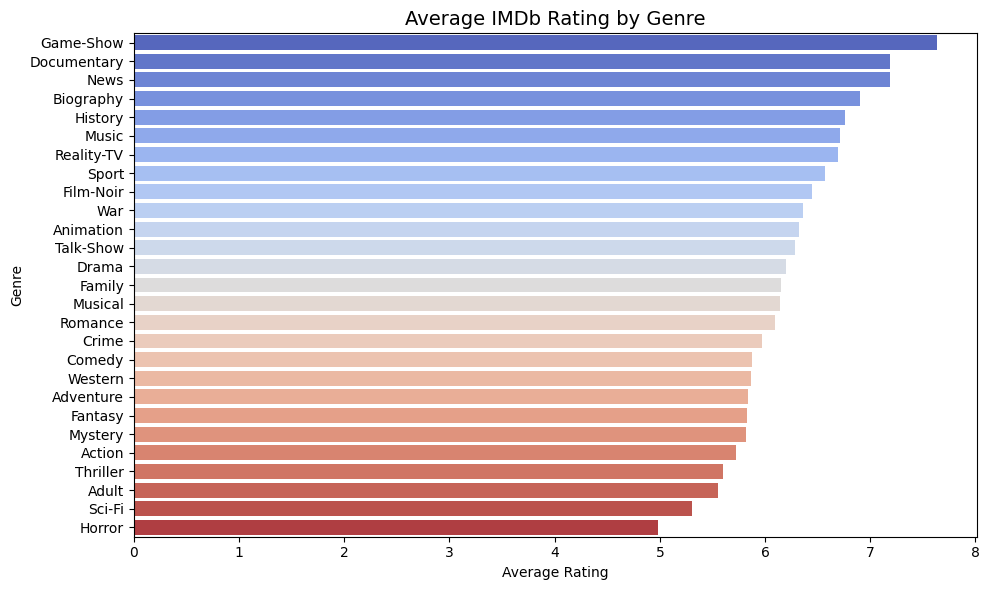

In [24]:
# Average Rating per Genre

query = """
SELECT 
    g.genreName AS genre,
    ROUND(AVG(r.averageRating), 2) AS avg_rating,
    COUNT(*) AS num_movies
FROM dim_movie AS m
JOIN title_genre_bridge AS tg ON m.tconst = tg.tconst
JOIN genre_dt AS g ON tg.genreID = g.genreID
JOIN title_ratings AS r ON m.tconst = r.tconst
GROUP BY g.genreName
ORDER BY avg_rating DESC;
"""

with engine.connect() as conn:
    genre_ratings = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
sns.barplot(x="avg_rating", y="genre", hue="genre", data=genre_ratings, palette="coolwarm")
plt.title("Average IMDb Rating by Genre", fontsize=14)
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

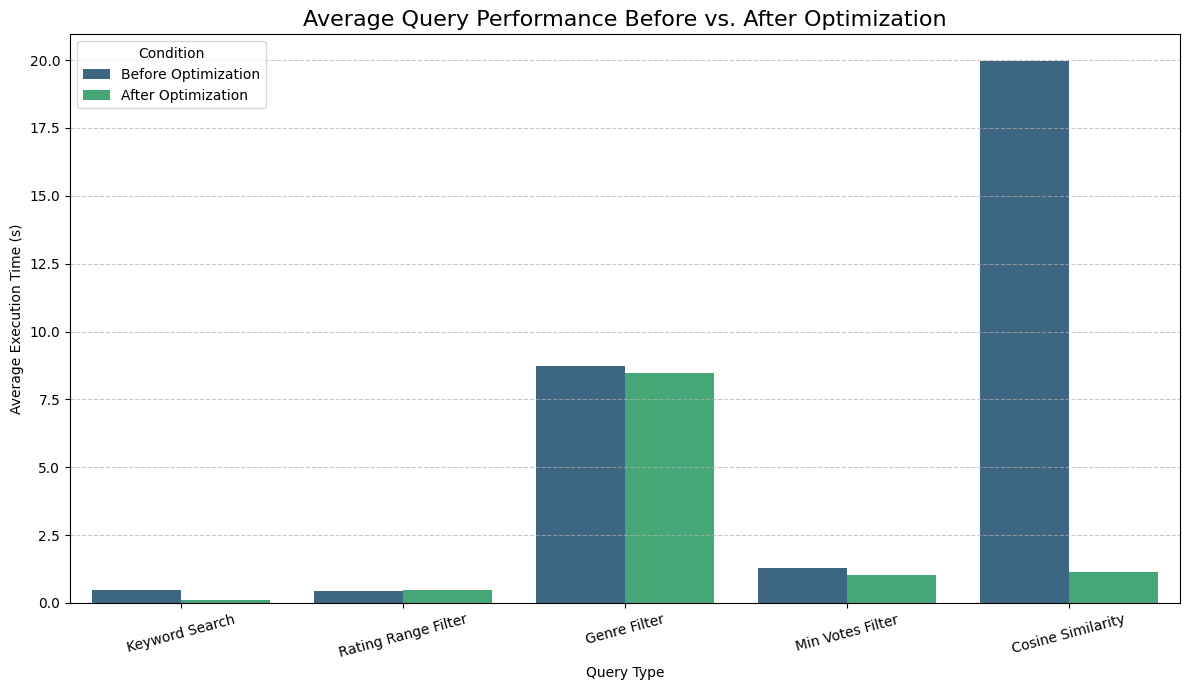

In [40]:
# Updated Average Execution Time

performance_data = {
    "Query": [
        "Keyword Search", "Keyword Search",
        "Rating Range Filter", "Rating Range Filter",
        "Genre Filter", "Genre Filter",
        "Min Votes Filter", "Min Votes Filter",
        "Cosine Similarity", "Cosine Similarity"
    ],
    "Condition": [
        "Before Optimization", "After Optimization",
        "Before Optimization", "After Optimization",
        "Before Optimization", "After Optimization",
        "Before Optimization", "After Optimization",
        "Before Optimization", "After Optimization"
    ],
    "Time (s)": [
        0.465, 0.110,  # Keyword
        0.438, 0.489,  # Rating
        8.733, 8.465,  # Genre
        1.284, 1.017,  # Min Votes
        19.951, 1.151   # Cosine Similarity
    ]
}
perf_df = pd.DataFrame(performance_data)
plt.figure(figsize=(12, 7))
sns.barplot(x="Query", y="Time (s)", hue="Condition", data=perf_df, palette="viridis")
plt.title("Average Query Performance Before vs. After Optimization", fontsize=16)
plt.ylabel("Average Execution Time (s)")
plt.xlabel("Query Type")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Condition")
plt.tight_layout()
plt.show()

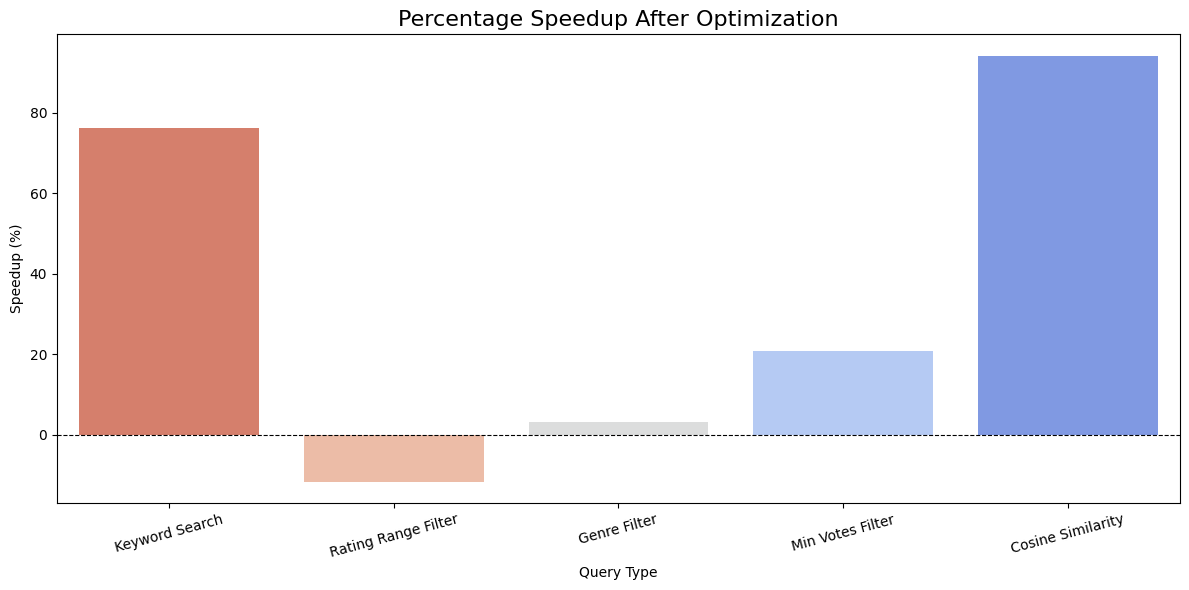

In [41]:
# Percentage Speedup

speedup_data = {
    "Query": ["Keyword Search", "Rating Range Filter", "Genre Filter", "Min Votes Filter", "Cosine Similarity"],
    "Percent Speedup": [76.3, -11.6, 3.1, 20.8, 94.2]
}
speedup_df = pd.DataFrame(speedup_data)

plt.figure(figsize=(12, 6))
sns.barplot(x="Query", y="Percent Speedup", data=speedup_df, palette="coolwarm_r", hue="Query", dodge=False)
plt.title("Percentage Speedup After Optimization", fontsize=16)
plt.ylabel("Speedup (%)")
plt.xlabel("Query Type")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend([],[], frameon=False) 
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()